In [25]:
import numpy as np
import cv2
import os
import sys
import matplotlib.pyplot as plt
import gc
import networkx as nx
import scipy.sparse as sp
import math

In [2]:
xyz = np.genfromtxt("stanford-rwc---paracosm_floor-west-tower_processed-scan.xyz", delimiter=' ', skip_header=0)
print(xyz[0])

[ 32.49479585  39.88767065  13.14775633]


In [16]:
print(np.min(xyz[:,2]), np.max(xyz[:,2]))

(2.5516969008458705, 15.051989962965838)


In [3]:
minx = np.min(xyz[:,0])
miny = np.min(xyz[:,1])
minz = np.min(xyz[:,2])
maxx = np.max(xyz[:,0])
maxy = np.max(xyz[:,1])
maxz = np.max(xyz[:,2])

In [48]:
print minx, maxx, miny, maxy, minz, maxz

19.9769142993 33.4780283284 33.8283985078 42.0073171665 2.55169690085 15.051989963


199756


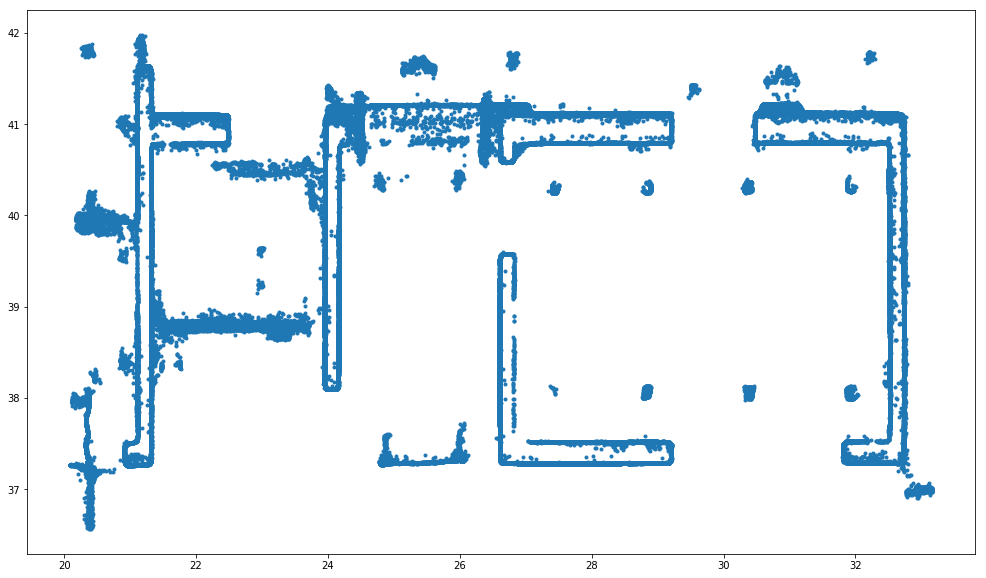

In [4]:
elev = 9
epsz = .125
xlow = 0
xhigh = 50
ylow = 0
yhigh = 50

ll = np.array([xlow, ylow, elev-epsz])  # lower-left
ur = np.array([xhigh, yhigh, elev+epsz])  # upper-right

inidx = np.all(np.logical_and(ll <= xyz, xyz <= ur), axis=1)
quad = xyz[inidx]

print len(quad)
fig = plt.figure(figsize=(17, 10))
f1 = fig.add_subplot(111)
f1.plot(quad[:,0], quad[:,1], '.')

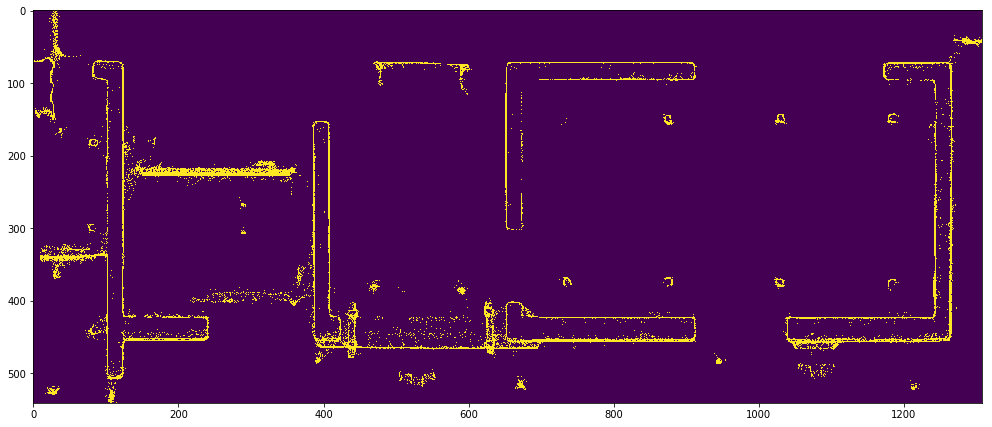

In [20]:
minqx = np.min(quad[:, 0])
maxqx = np.max(quad[:, 0])
minqy = np.min(quad[:, 1])
maxqy = np.max(quad[:, 1])

slice = np.zeros((int(maxqy*100)+1, int(maxqx*100)+1))
for i in range(quad.shape[0]):
    slice[int(quad[i][1]*100), int(quad[i][0]*100)] = 255

slice = slice[int(minqy*100):int(maxqy*100), int(minqx*100):int(maxqx*100)]
fig = plt.figure(figsize=(17, 10))
ax = fig.add_subplot(111)
ax.imshow(slice)

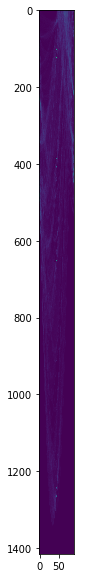

In [28]:
rho_res = 1
theta_res = math.pi/90

pi = math.pi
# Get non-zero points in vector form
points = np.transpose(np.nonzero(slice))

# Get array of theta values from 0 to pi in increments of theta res
theta = np.arange(0,pi+theta_res,theta_res)

# Get max radius size
x_size = slice.shape[1]
y_size = slice.shape[0]
d_max = np.sqrt(x_size**2+y_size**2)

# Set scale of rho vector from 0 to max radius in increments of rho res
rho = np.arange(0,int(d_max+rho_res),rho_res)
# Initialize hough array to rho size rows and theta size columns
H = np.zeros((rho.size,theta.size))

# Compute values in Hough array. For every nonzero pixel and every theta, compute d and add vote to hough array
for p in range(0,points.size/2):
    #print points[p]
    for t in range(0,theta.size):
        d = int(points[p,0]*np.cos(theta[t])+points[p,1]*np.sin(theta[t]))
        d = abs(d)
        r_idx = np.argwhere(rho==d)          
        r = rho[int(r_idx[0])]
        H[r,t]+=1

# Normalize Hough array to 0-255 and convert to UINT8
H = cv2.normalize(H, None, 0,255,cv2.NORM_MINMAX)
H = cv2.convertScaleAbs(H)

fig = plt.figure(figsize=(17, 10))
ax = fig.add_subplot(111)
ax.imshow(H)

In [48]:
Q = 20
print np.min(H)
print np.max(H)
peaks = np.empty((Q,2))
T = 125

ret,thresh1 = cv2.threshold(H,T,255,cv2.THRESH_BINARY)
peak_candidates = np.transpose(np.nonzero(thresh1))
print peak_candidates.shape
i=0
while(i<(peak_candidates[:,0].size)-1):
    if abs(peak_candidates[i,0]-peak_candidates[i+1,0])<5 and abs(peak_candidates[i,1]-peak_candidates[i+1,1])<5:
        peak_candidates = np.delete(peak_candidates,i,axis=0)
    else:
        i+=1


peaks = peak_candidates[0:Q,:]


0
255
(22L, 2L)


(20L, 2L)
(1265, -999) (1265, 1000)


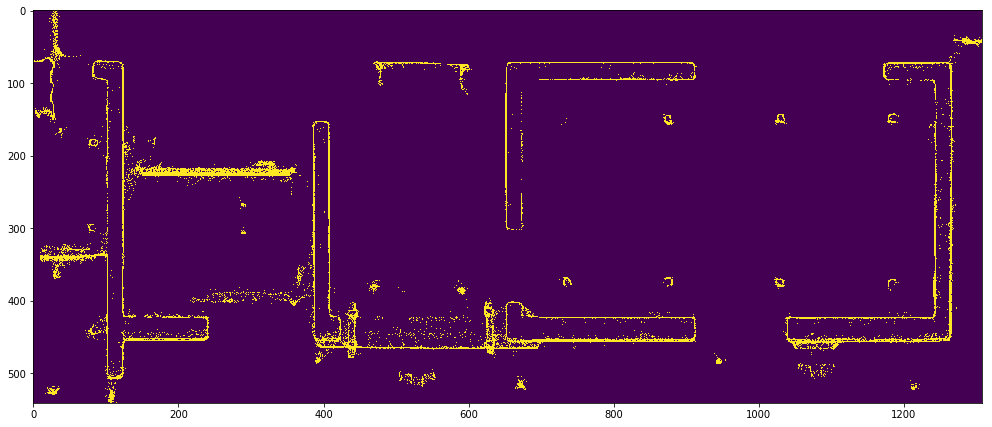

In [54]:
img_out = np.copy(slice)
print peaks.shape
while(i<peaks[:,0].size):
    rho1 = rho[peaks[i,0]]
    theta1 = theta[peaks[i,1]]
    theta1 = theta1
    a = np.cos(theta1)
    b = np.sin(theta1)
    x = rho1*a 
    y = rho1*b
    p1 = (int(y+1000*(a)),int(x+1000*(-b)))
    p2 = (int(y-1000*(a)),int(x-1000*(-b)))
    
    cv2.line(img_out,p2,p1,(0,100,100),3,0,0)
    i+=1
print p1, p2
fig = plt.figure(figsize=(17, 10))
ax = fig.add_subplot(111)
ax.imshow(img_out)